# 1. Bayesian Experiments
In our [previous notebook](https://www.kaggle.com/carlossouza/probabilistic-machine-learning-a-diff-approach), we publishe a different approach to the competition: training a **Bayesian Linear Regression model** that could not only predict the decline in FVC for each patient but also the confidence. The key benefit of **Probabilistic Machine Learning models** is that they are very good at predicting uncertainty, which is required in several applications such as personalized medicine.

However, the first model was not that simple. We used all tabular data and engineered features, creating a hierarquical model with several parameters. The model was **very unstable**, and its submissions only occasionally generated results without **errors**. The purpose of this notebook is to fix that. Our goals are:
1. Build a stable **error-free** simplest possible **Bayesian Hierarchical Linear Regression model**
2. Extend this model to use **more tabular data**
3. **Compare a visualize** both models
4. Submit the best model solution

# 2. A simpler way to look at the data
Several notebooks, including our first notebook, add a column feature of baseline FVC and Percent. Then, they go on and calculate the time difference in weeks between the baseline FVC and the target FVC to be predicted. We gave a lot of thought on these engineered features, and we decided to **drop them and experiment using a simpler dataset**.

Let us explain why. We believe adding the baseline FVC and Percent and calculating the time difference in weeks between the baseline FVC and the target FVC to be predicted makes sense **only when we are not informing the model about who the patient is**. However, **that's completely unnecessary when we inform the model who the patients are**, identifying the owner of each data point.

But informing the model about who the patients are wouldn't be a form of data leakage? Again, after giving a lot of thought, we believe that's not the case. **We must inform the model who the patients are**. That's because **the data points are NOT independent**. FVC measures from a given patient are **strongly correlated**. We should not discard that information, it is too valuable.

The insight that sparked this line of thought was to look at this problem as a **matrix completion** task. It resembles a recommender system challenge or a missing value imputation challenge, such as 2009's [Netflix Prize](https://www.netflixprize.com/). The image below reframes how we are proposing looking at the problem:

<img src="https://i.ibb.co/0Z9kW8H/matrix-completion.jpg" alt="drawing" width="800"/>

Usually in a recommendation engine, the rows are the customers, the columns are the products (e.g. Amazon) or movies (e.g. Netflix), and the cells are ratings from 1 to 5. Collaborative filtering techniques, such as Probabilistic Matrix Factorization, are used to **fill in this (very sparse) table**, recommending new products that users might like on the basis of reactions by **similar users**. The data points (ratings) from a given user are **strongly correlated**; and **by informing who the users are, the model learns to group users with similar interests**.

The same way of thinking can be applied in this competition. A model might **learn to appropriately group patients** by inferring the stage of the disease, only by being fed with the FVC decline curves from each patient (with several missing values!). Of course there are differences: in a recommender AI system, the order of the columns doesn't matter, and the missing values are constrained in the interval [1, 5]. Here, **the order of the columns matter** (time growing from left to right), and the FVC values are not constrained in a particular interval. Nevertheless, we believe we can benefit from seeing the similarities between these 2 worlds and adjusting the algorithms accordingly where they diverge.

To prove that this approach works (and actually produces good results!), in the first model we will use only:
- FVC
- Week
- Patient ID

You might argue it will be "easy" for a model to predict future FVC measures once it is trained with several past FVC measures from a given patient. So, **we will make it harder: we will remove all data points from the 5 test patients from the training set**, except the first baseline FVC measurement. This means that **our model will have only a single point** from these 5 patients to use in order to generate future FVC predictions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
exclude_test_patient_data_from_trainset = True

train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

if exclude_test_patient_data_from_trainset:
    train = train[~train['Patient'].isin(test['Patient'].unique())]

train = pd.concat([train, test], axis=0, ignore_index=True)\
    .drop_duplicates()

le_id = LabelEncoder()
train['PatientID'] = le_id.fit_transform(train['Patient'])

train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,0


And for now, that's all there is to data pre-processing! We can again just inspect the FVC declines:

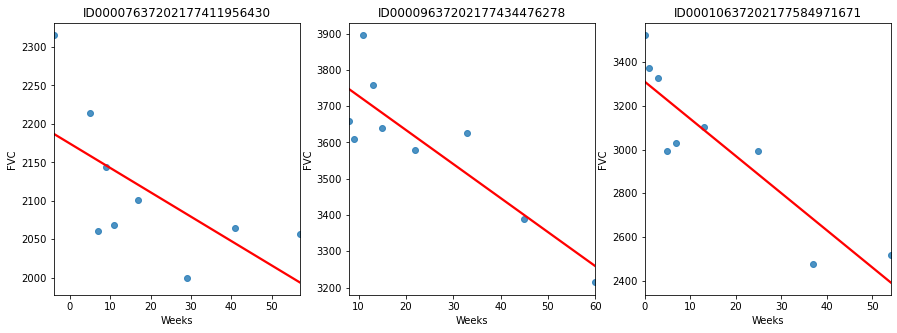

In [3]:
def chart(patient_id, ax):
    data = train[train['Patient'] == patient_id]
    x = data['Weeks']
    y = data['FVC']
    ax.set_title(patient_id)
    ax = sns.regplot(x, y, ax=ax, ci=None, line_kws={'color':'red'})
    

f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart('ID00007637202177411956430', axes[0])
chart('ID00009637202177434476278', axes[1])
chart('ID00010637202177584971671', axes[2])

# 3. Model A: Bayesian Hierarchical Linear Regression with Partial Pooling
Our first model (A) is the simplest possible Bayesian Hierarchical Linear Regression model. It assumes **every patient has a personalized FVC decline curve**, with a single intercept ($\alpha$) and slope ($\beta$).

Actually the simplest possible linear regression, not hierarchical, would assume all FVC decline curves have the same $\alpha$ and $\beta$. That's the **pooled model**. In the other extreme, we could assume a model where each patient has a personalized FVC decline curve, **and these curves are completely unrelated**. That's the **unpooled model**, where each patient has completely separate regressions.

Here, we will use the middle ground: **Partial pooling**. Specifically, we will assume that while $\alpha$'s and $\beta$'s are different for each patient as in the unpooled case, the **coefficients all share similarity**. We can model this by assuming that each individual coefficient comes from a common group distribution. For more details about these 3 different ways of modelling, check [GLM: Hierarchical Linear Regression](https://docs.pymc.io/notebooks/GLM-hierarchical.html) great tutorial. The graphic model below represents this model:

<img src="https://i.ibb.co/H7NgBfR/Artboard-2-2x-100.jpg" alt="drawing" width="600"/>

Mathematically, the model is described by the following equations:
$$
\mu_{\alpha} \sim \mathcal{N}(1700, 400) \\
\sigma_{\alpha} \sim |\mathcal{N}(0, 1000)| \\
\mu_{\beta} \sim \mathcal{N}(-4, 1) \\
\sigma_{\beta} \sim |\mathcal{N}(0, 5)| \\
\alpha_i \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}) \\
\beta_i \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) \\
\sigma \sim |\mathcal{N}(0, 150)| \\
FVC_{ij} \sim \mathcal{N}(\alpha_i + t \beta_i, \sigma)
$$

where *t* is the time in weeks. You might ask why we have chosen these specific priors. We did some iterations, at first with pretty vague/uninformative priors. After observing the first results, we converged to these distributions described above. Although PyMC3 samplers can work pretty well with uninformative priors, other PPLs such as Pyro requires more specific priors (otherwise their samplers take a really long time to converge).

Implementing it in PyMC3 is very straightforward:

In [4]:
import pymc3 as pm

In [5]:
n_patients = train['Patient'].nunique()
FVC_obs = train['FVC'].values
Weeks = train['Weeks'].values
PatientID = train['PatientID'].values

In [6]:
with pm.Model() as model_a:
    # create shared variables that can be changed later on
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs)
    Weeks_shared = pm.Data('Weeks_shared', Weeks)
    PatientID_shared = pm.Data('PatientID_shared', PatientID)
    
    mu_a = pm.Normal('mu_a', mu=1700., sigma=400)
    sigma_a = pm.HalfNormal('sigma_a', 1000.)
    mu_b = pm.Normal('mu_b', mu=-4., sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_patients)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_patients)

    # Model error
    sigma = pm.HalfNormal('sigma', 150.)

    FVC_est = a[PatientID_shared] + b[PatientID_shared] * Weeks_shared

    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                         sigma=sigma, observed=FVC_obs_shared)

# 4. Fiting model A
Just press the inference button (TM)! :)

In [7]:
# Inference button (TM)!
with model_a:
    trace_a = pm.sample(2000, tune=2000, target_accept=.9, init="adapt_diag")

# 5. Checking model A
## 5.1. Inspecting the learned parameters
First, let's inspect the parameters learned:

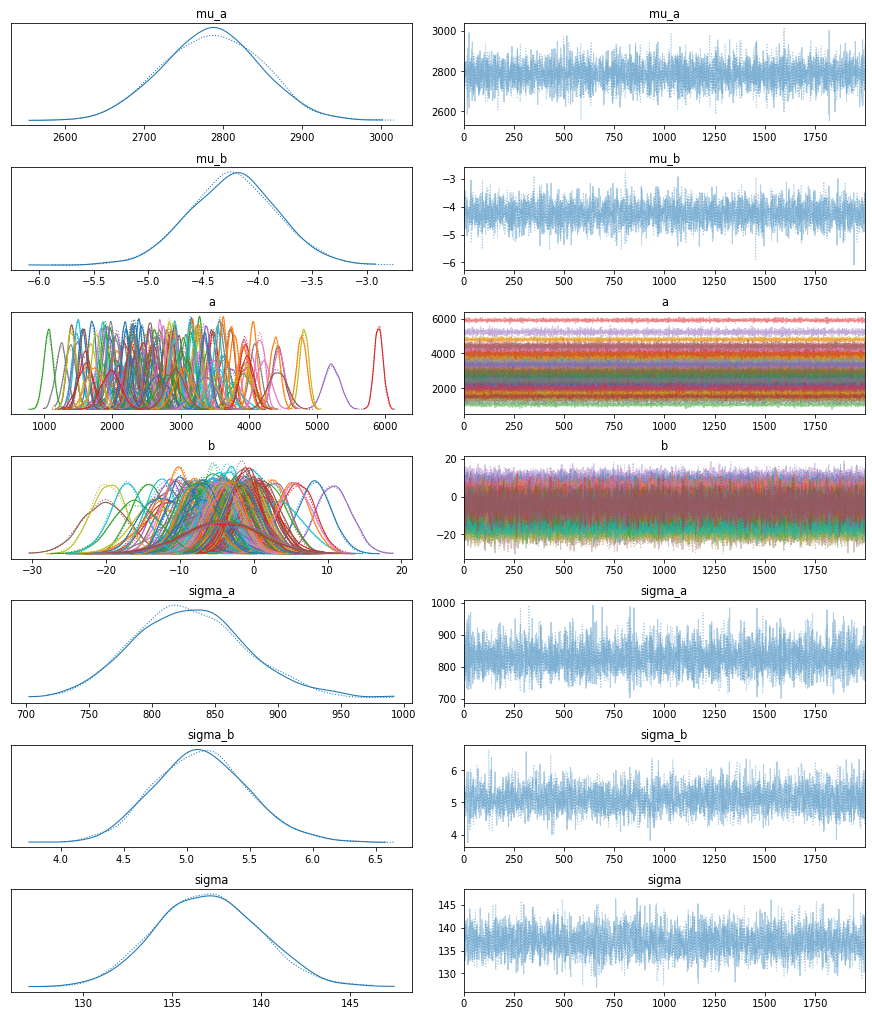

In [8]:
with model_a:
    pm.traceplot(trace_a);

Great! It looks like our model learned different $\alpha$'s and $\beta$'s for each patient, pooled from the same source distribution.

## 5.2. Visualizing FVC decline curves for some patients
Now, let's visually inspect FVC decline curves predicted by our model. We will completely fill in the FVC table, predicting all missing values. The first step is to create a table to fill:

In [9]:
pred_template = []
for i in range(train['Patient'].nunique()):
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['PatientID'] = i
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)

Now, let's generate all predictions and fill in the table:

In [10]:
with model_a:
    pm.set_data({
        "PatientID_shared": pred_template['PatientID'].values.astype(int),
        "Weeks_shared": pred_template['Weeks'].values.astype(int),
        "FVC_obs_shared": np.zeros(len(pred_template)).astype(int),
    })
    post_pred = pm.sample_posterior_predictive(trace_a)

In [11]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df['Patient'] = le_id.inverse_transform(pred_template['PatientID'])
df['Weeks'] = pred_template['Weeks']
df['FVC_pred'] = post_pred['FVC_like'].T.mean(axis=1)
df['sigma'] = post_pred['FVC_like'].T.std(axis=1)
df['FVC_inf'] = df['FVC_pred'] - df['sigma']
df['FVC_sup'] = df['FVC_pred'] + df['sigma']
df = pd.merge(df, train[['Patient', 'Weeks', 'FVC']], how='left', on=['Patient', 'Weeks'])
df = df.rename(columns={'FVC': 'FVC_true'})
df.head()

,Patient,Weeks,FVC_pred,sigma,FVC_inf,FVC_sup,FVC_true
0,ID00007637202177411956430,-12,2225.165295,159.436059,2065.729236,2384.601354,NaN
1,ID00007637202177411956430,-11,2223.121346,157.737362,2065.383984,2380.858708,NaN
2,ID00007637202177411956430,-10,2217.029402,158.633245,2058.396157,2375.662648,NaN
3,ID00007637202177411956430,-9,2212.786046,155.782152,2057.003895,2368.568198,NaN
4,ID00007637202177411956430,-8,2207.682971,158.406884,2049.276087,2366.089854,NaN


Now, let's visualize the predictions for 6 patients:
- In the first row, we can see predictions for 3 patients for which our model had several points to learn personalized $\alpha$'s and $\beta$'s
- In the second row, we can see predictions for 3 patients for which our model had only a single point to learn personalized $\alpha$'s and $\beta$'s

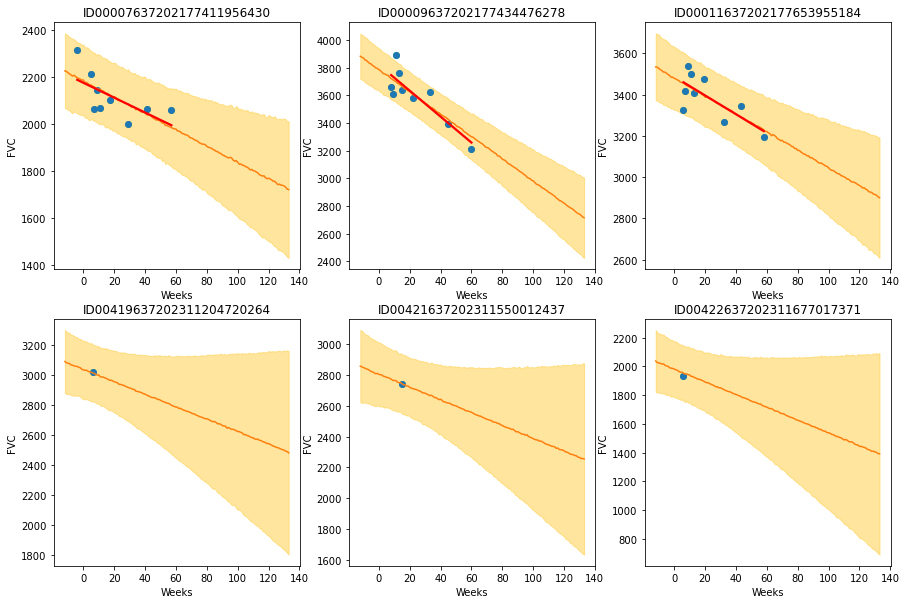

In [12]:
def chart(patient_id, ax):
    data = df[df['Patient'] == patient_id]
    x = data['Weeks']
    ax.set_title(patient_id)
    ax.plot(x, data['FVC_true'], 'o')
    ax.plot(x, data['FVC_pred'])
    ax = sns.regplot(x, data['FVC_true'], ax=ax, ci=None, 
                     line_kws={'color':'red'})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"],
                    alpha=0.5, color='#ffcd3c')
    ax.set_ylabel('FVC')

f, axes = plt.subplots(2, 3, figsize=(15, 10))
chart('ID00007637202177411956430', axes[0, 0])
chart('ID00009637202177434476278', axes[0, 1])
chart('ID00011637202177653955184', axes[0, 2])
chart('ID00419637202311204720264', axes[1, 0])
chart('ID00421637202311550012437', axes[1, 1])
chart('ID00422637202311677017371', axes[1, 2])

The results are exactly what we expected to see! Highlight observations:
- The model adequately learned Bayesian Linear Regressions! The orange line (learned predicted FVC mean) is very inline with the red line (deterministic linear regression). But most important: it learned to predict uncertainty, showed in the light orange region (one sigma above and below the mean FVC line)
- In the first row, where the model had several points for each patient, we can see the model predicts a higher uncertainty where the data points are more disperse (1st and 3rd patients). Conversely, where the points are more grouped together (2nd patient, first row), the model predicts a higher confidence (narrower light orange region)
- In the 2nd row, we can see our model does a good job even when we supply it with only a single data point per patient to use as base to make inferences!
- Comparing the first 3 patients in the first row with the last 3 patients on the 2nd row, we can see that our model correctly estimates a higher confidence for the first 3 patients, for which it had more data points to make inferences!
- Finally, in all 6 patients, we can see that the uncertainty grows as the look more into the future: the light orange region widens as the # of weeks grow! That makes a lot of sense!

## 5.3. Computing the modified Laplace Log Likelihood and RMSE
These are straightforward to compute:

In [13]:
# Add the test data points back to calculate the metrics
tr = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
df = pd.merge(df, tr[['Patient', 'Weeks', 'FVC']], how='left', on=['Patient', 'Weeks'])

use_only_last_3_measures = True

if use_only_last_3_measures:
    y = df.dropna().groupby('Patient').tail(3)
else:
    y = df.dropna()

rmse = ((y['FVC_pred'] - y['FVC']) ** 2).mean() ** (1/2)
print(f'RMSE: {rmse:.1f} ml')

sigma_c = y['sigma'].values
sigma_c[sigma_c < 70] = 70
delta = (y['FVC_pred'] - y['FVC']).abs()
delta[delta > 1000] = 1000
lll = - np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f'Laplace Log Likelihood: {lll.mean():.4f}')

RMSE: 113.9 ml
Laplace Log Likelihood: -6.1446


These look like very encouraging numbers, especially taking into consideration that **we only used 3 columns: FVC, weeks and Patient ID**, discarding all the rest. Now, let's go to the 2nd objective.

# 6. Extending the model to use more tabular data
We will implement very few changes to make our model use all possible tabular data. The first is simply one-hot encode the categorical features **Sex** and **SmokingStatus**. In order to avoid multicollinearity issues, we will drop the last column after transforming both. (For more about multicollinearity issues, check [here](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/)). The second is adding **percent at baseline** feature.

In [14]:
train['Male'] = train['Sex'].apply(lambda x: 1 if x == 'Male' else 0)

train["SmokingStatus"] = train["SmokingStatus"].astype(
    pd.CategoricalDtype(['Ex-smoker', 'Never smoked', 'Currently smokes'])
)
aux = pd.get_dummies(train["SmokingStatus"], prefix='ss')
aux.columns = ['ExSmoker', 'NeverSmoked', 'CurrentlySmokes']
train['ExSmoker'] = aux['ExSmoker']
train['CurrentlySmokes'] = aux['CurrentlySmokes']

aux = train[['Patient', 'Weeks', 'Percent']].sort_values(by=['Patient', 'Weeks'])
aux = train.groupby('Patient').head(1)
aux = aux.rename(columns={'Percent': 'Percent_base'})
train = pd.merge(train, aux[['Patient', 'Percent_base']], how='left',
                 on='Patient')

train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,Male,ExSmoker,CurrentlySmokes,Percent_base
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,0,1,1,0,58.253649
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,0,1,1,0,58.253649
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,0,1,1,0,58.253649
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,0,1,1,0,58.253649
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,0,1,1,0,58.253649


And that's all there is to it.

# 7. Model B: Hierarchical Model with Partial Pooling using more tabular data
The model is essentially the same as model A. There is, though, a slight change. The equation that predicts the FVC is changed to:

$$
FVC_{ij} \sim \mathcal{N}(\alpha_i + X_{ij} \beta_i, \sigma)
$$


Now, multiplying $\beta_i$ we have $X_{ij}$ instead of *t*. $X_{ij}$ is a vector of the patient *i* at timestep *j* that contains:
- Male binary code from patient *i* at timestep *j* (which is constant at all timesteps)
- Ex-smoker binary code from patient *i* at timestep *j* (which is constant at all timesteps)
- Currently-smokes binary code from patient *i* at timestep *j* (which is constant at all timesteps)
- Percent from patient *i* at baseline moment
- The week (timestep *j*)

Some good questions and our best answers:
- Why aren't you including **age**? Empirically, when we add age to the features, it significantly degrades the model performance. Don't know exactly why this happens. We hypothesize that this is due to multicollinearity. Anyways, in a model trained to predict personalized curves of FVC decline, in which we inform the Patient ID, in theory everything that qualifies the patient should be already encoded in its ID.
- Why are you considering **Percent at baseline moment** only, discarding the other values? That's a very good question :) The percent feature varies in time, and it is strongly correlated with FVC (the variable we are interested in predicting). However, at inference time, we don't have percent feature in every week from [-12, 133]; we only have the percent at baseline moment. At inference time, if we consider percent flat from week -12 to week 133 (as we saw in some notebooks), that would be conceptually wrong IMHO. The only number we have is the percent at baseline moment. So, that's the number we feed our model.


In [15]:
n_patients = train['Patient'].nunique()
FVC_obs = train['FVC'].values
X = train[['Weeks', 'Male', 'ExSmoker', 'CurrentlySmokes', 
           'Percent_base']].values
PatientID = train['PatientID'].values

In [16]:
with pm.Model() as model_b:
    # create shared variables that can be changed later on
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs)
    X_shared = pm.Data('X_shared', X)
    PatientID_shared = pm.Data('PatientID_shared', PatientID)
    
    mu_a = pm.Normal('mu_a', mu=1700, sigma=400)
    sigma_a = pm.HalfNormal('sigma_a', 1000.)
    mu_b = pm.Normal('mu_b', mu=-4., sigma=1., shape=X.shape[1])
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_patients)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=(n_patients, X.shape[1]))

    # Model error
    sigma = pm.HalfNormal('sigma', 150.)

    FVC_est = a[PatientID_shared] + (b[PatientID_shared] * X_shared).sum(axis=1)

    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                         sigma=sigma, observed=FVC_obs_shared)

# 8. Fiting model B
Just press the inference button (TM)! :)

In [17]:
# Inference button (TM)!
with model_b:
    trace_b = pm.sample(2000, tune=2000, target_accept=.9, init="adapt_diag")

# 9. Checking model B
## 9.1. Inspecting the learned parameters
First, let's inspect the parameters learned:

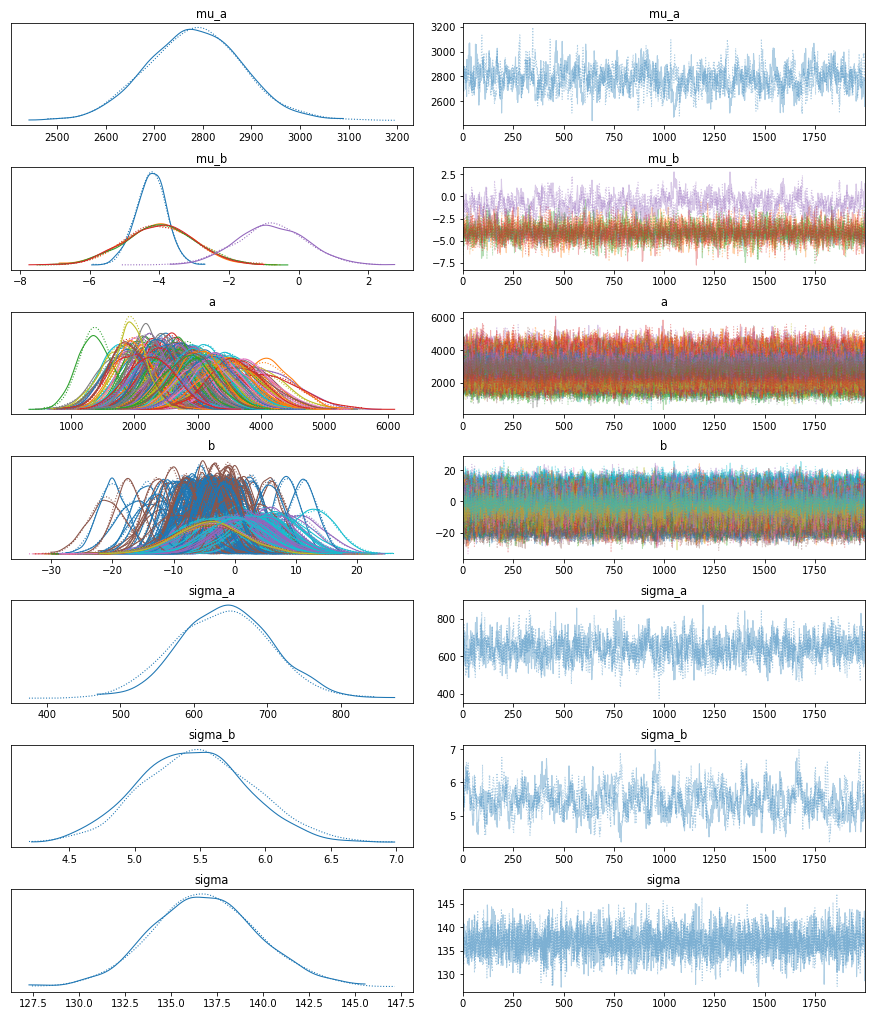

In [18]:
with model_b:
    pm.traceplot(trace_b);

Great! Again, it looks like our model learned different $\alpha$'s and $\beta$'s for each patient, pooled from the same source distribution. Note: this model is unstable, and sometimes do not converge.

## 9.2. Visualizing FVC decline curves for some patients
Now, let's visually inspect FVC decline curves predicted by our model. We will completely fill in the FVC table, predicting all missing values. The first step is to create a table to fill:

In [19]:
aux = train.groupby('Patient').first().reset_index()
pred_template = []
for i in range(train['Patient'].nunique()):
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['PatientID'] = i
    df['Male'] = aux[aux['PatientID'] == i]['Male'].values[0]
    df['ExSmoker'] = aux[aux['PatientID'] == i]['ExSmoker'].values[0]
    df['CurrentlySmokes'] = aux[aux['PatientID'] == i]['CurrentlySmokes'].values[0]
    df['Percent_base'] = aux[aux['PatientID'] == i]['Percent_base'].values[0]
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)

Now, let's fill the table:

In [20]:
with model_b:
    pm.set_data({
        "PatientID_shared": pred_template['PatientID'].values.astype(int),
        "X_shared": pred_template[['Weeks', 'Male', 'ExSmoker', 
                                   'CurrentlySmokes', 
                                   'Percent_base']].values.astype(int),
        "FVC_obs_shared": np.zeros(len(pred_template)).astype(int),
    })
    post_pred = pm.sample_posterior_predictive(trace_b)

In [21]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df['Patient'] = le_id.inverse_transform(pred_template['PatientID'])
df['Weeks'] = pred_template['Weeks']
df['FVC_pred'] = post_pred['FVC_like'].T.mean(axis=1)
df['sigma'] = post_pred['FVC_like'].T.std(axis=1)
df['FVC_inf'] = df['FVC_pred'] - df['sigma']
df['FVC_sup'] = df['FVC_pred'] + df['sigma']
df = pd.merge(df, train[['Patient', 'Weeks', 'FVC']], how='left', on=['Patient', 'Weeks'])
df = df.rename(columns={'FVC': 'FVC_true'})
df.head()

,Patient,Weeks,FVC_pred,sigma,FVC_inf,FVC_sup,FVC_true
0,ID00007637202177411956430,-12,2227.014803,160.576215,2066.438588,2387.591019,NaN
1,ID00007637202177411956430,-11,2220.814248,158.745735,2062.068512,2379.559983,NaN
2,ID00007637202177411956430,-10,2218.266241,158.219412,2060.046829,2376.485654,NaN
3,ID00007637202177411956430,-9,2212.222487,157.511520,2054.710967,2369.734008,NaN
4,ID00007637202177411956430,-8,2211.697043,157.260635,2054.436407,2368.957678,NaN


And finally, let's visualize again 6 patients, the same 6 we saw with Model A:

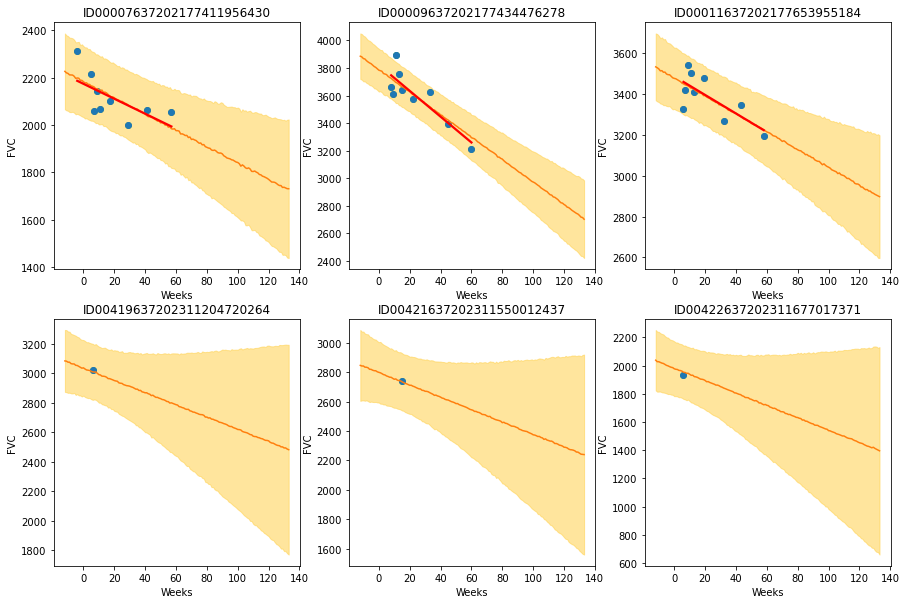

In [22]:
def chart(patient_id, ax):
    data = df[df['Patient'] == patient_id]
    x = data['Weeks']
    ax.set_title(patient_id)
    ax.plot(x, data['FVC_true'], 'o')
    ax.plot(x, data['FVC_pred'])
    ax = sns.regplot(x, data['FVC_true'], ax=ax, ci=None, 
                     line_kws={'color':'red'})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"],
                    alpha=0.5, color='#ffcd3c')
    ax.set_ylabel('FVC')

f, axes = plt.subplots(2, 3, figsize=(15, 10))
chart('ID00007637202177411956430', axes[0, 0])
chart('ID00009637202177434476278', axes[0, 1])
chart('ID00011637202177653955184', axes[0, 2])
chart('ID00419637202311204720264', axes[1, 0])
chart('ID00421637202311550012437', axes[1, 1])
chart('ID00422637202311677017371', axes[1, 2])

It looks like Model B generates the same results as Model A. Note: this model is unstable, and sometimes do not converge.

## 9.3. Computing the modified Laplace Log Likelihood and RMSE
Finally, let's check the metrics for model B:

In [23]:
# Add the test data points back to calculate the metrics
tr = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
df = pd.merge(df, tr[['Patient', 'Weeks', 'FVC']], how='left', on=['Patient', 'Weeks'])

use_only_last_3_measures = True

if use_only_last_3_measures:
    y = df.dropna().groupby('Patient').tail(3)
else:
    y = df.dropna()

rmse = ((y['FVC_pred'] - y['FVC_true']) ** 2).mean() ** (1/2)
print(f'RMSE: {rmse:.1f} ml')

sigma_c = y['sigma'].values
sigma_c[sigma_c < 70] = 70
delta = (y['FVC_pred'] - y['FVC_true']).abs()
delta[delta > 1000] = 1000
lll = - np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f'Laplace Log Likelihood: {lll.mean():.4f}')

RMSE: 113.2 ml
Laplace Log Likelihood: -6.1409


Again, we see good encouraging numbers (Note: this model is unstable, and sometimes do not converge.). However, these are remarkably close to the numbers we obtained when we used only FVC, weeks and Patient ID - actually a little bit worse. Why is that the case? **Why aren't these new features helping the model?** We discuss this question and other learnings in the next section.

# 10. Discussion
Our first objective was to **build a stable error-free simplest possible Bayesian Hierarchical Linear Regression model**. We achieved it, implementing a model with partial pooling, where **each patient has a personalized FVC decline curve with personalized parameters**, but **all these parameters share similarities**, being drawn from the same shared distributions.

The results observed from the experiment with model A met our expectations. The model adequately learned not only to predict good FVC declines (low RMSE) but also **learned to properly gauge confidence** (low Laplace Log Likelihood). We saw that our model effectively made predictions **even in the challenging situation where it had only a single FVC measure** to base its future FVC forecasts. We visually saw **higher predicted confidence when the FVC data points were grouped together** in a more clear line, and a **lower predicted confidence when the FVC measurements were more disperse**. Our model was also able to properly predict **decreasing confidence as we looked more and more into the future**.

While experimenting with model B, our 2nd objective, we had to **deal with multicollinearity**, a common problem of linear regression models in high dimensions. After dropping some features to avoid it, we were able to observe the results, which were very similar than the ones obtained with model A. So, with this modelling, **new features did not improve our predictive error**.

We hypothesise that this happens because **all the information that qualifies a patient is already encoded in the Patient ID**. Once we feed the model with this information, nothing else matters: it is the maximum of personalisation. Any other feature that groups patients are, by definition, more general than the Patient ID (the maximum of personalisation). This refers back to the original idea that sparked this line of thought: **collaborative filtering**. There are basically 2 approaches to mass-customize recommendations (adopted by giants such as Amazon, Netflix, Facebook, etc): collaborative filtering and content-base filtering. The former learns to group similar users based on their ratings (nothing else matters), while the latter recommends based on user & item’s features. So, the fact that model B produce similar scores of model A, even with more features, is **consistent with the adopted approach**.

Maybe with a larger base of patients, more features would help the model to group them together. However, only 176 patients is too few. 

## Occam’s Razor

Now, let’s re-train the model using all data, and submit a solution. **But which model, A or B?**

The principle of simplicity in scientific models and theories is commonly called Ockham's razor, or Occham's razor. It is popularly attributed to 1400s English friar and philosopher William of Ockham, also known as William of Occham. The razor alludes to the shaving away of unneeded detail. A common paraphrase of Ockham's principle, originally written in Latin, is **"All things being equal, the simplest solution tends to be the best one."**

This is such a popular concept that we will leave [Lisa Simpson’s explanation of Occam’s Razor principle](https://www.youtube.com/watch?v=Ly0YzGpi63M) as our final remark :)

# 11. Final submission

In [24]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
train = pd.concat([train, test], axis=0, ignore_index=True)\
    .drop_duplicates()
le_id = LabelEncoder()
train['PatientID'] = le_id.fit_transform(train['Patient'])

In [25]:
n_patients = train['Patient'].nunique()
FVC_obs = train['FVC'].values
Weeks = train['Weeks'].values
PatientID = train['PatientID'].values

with pm.Model() as model_a:
    # create shared variables that can be changed later on
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs)
    Weeks_shared = pm.Data('Weeks_shared', Weeks)
    PatientID_shared = pm.Data('PatientID_shared', PatientID)
    
    mu_a = pm.Normal('mu_a', mu=1700., sigma=400)
    sigma_a = pm.HalfNormal('sigma_a', 1000.)
    mu_b = pm.Normal('mu_b', mu=-4., sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_patients)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_patients)

    # Model error
    sigma = pm.HalfNormal('sigma', 150.)

    FVC_est = a[PatientID_shared] + b[PatientID_shared] * Weeks_shared

    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                         sigma=sigma, observed=FVC_obs_shared)
    
    # Fitting the model
    trace_a = pm.sample(2000, tune=2000, target_accept=.9, init="adapt_diag")

In [26]:
pred_template = []
for p in test['Patient'].unique():
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['Patient'] = p
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)
pred_template['PatientID'] = le_id.transform(pred_template['Patient'])

with model_a:
    pm.set_data({
        "PatientID_shared": pred_template['PatientID'].values.astype(int),
        "Weeks_shared": pred_template['Weeks'].values.astype(int),
        "FVC_obs_shared": np.zeros(len(pred_template)).astype(int),
    })
    post_pred = pm.sample_posterior_predictive(trace_a)

In [27]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'Patient_Week', 'FVC', 'Confidence'])
df['Patient'] = pred_template['Patient']
df['Weeks'] = pred_template['Weeks']
df['Patient_Week'] = df['Patient'] + '_' + df['Weeks'].astype(str)
df['FVC'] = post_pred['FVC_like'].T.mean(axis=1)
df['Confidence'] = post_pred['FVC_like'].T.std(axis=1)
final = df[['Patient_Week', 'FVC', 'Confidence']]
final.to_csv('submission.csv', index=False)
print(final.shape)
final.head()

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2868.132188,161.835282
1,ID00419637202311204720264_-11,2867.097990,162.170769
2,ID00419637202311204720264_-10,2864.471133,159.838565
3,ID00419637202311204720264_-9,2859.127403,158.920961
4,ID00419637202311204720264_-8,2855.144337,157.545562


**Next step:**
- Replace the linear model by a non-linear model... isn't that obvious?! :)

<img src="https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg" alt="drawing" width="800"/>